In [1]:
from xvfbwrapper import Xvfb

#vdisplay = Xvfb()
#vdisplay.start()

# for environ
import os

# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["LIBGL_ALWAYS_SOFTWARE"]="1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# importing tensorflow
import tensorflow as tf

# import scipy
import scipy, csv

import pandas as pd

In [2]:
import gym
from gym import wrappers
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# to display environment data
# see https://gist.github.com/thomelane/79e97630ba46c45985a946cae4805885
from IPython import display

In [3]:
import sys
sys.path += ['/localhome/volodin/local/usr/bin']
sys.path

['',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python36.zip',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/lib-dynload',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/extensions',
 '/localhome/volodin/.ipython',
 '/localhome/volodin/local/usr/bin']

In [4]:
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

In [5]:
tf.reset_default_graph()
# allowing GPU memory growth to allocate only what we need
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph = tf.get_default_graph())

In [6]:
env = gym.make('CartPole-v0')
#env = wrappers.Monitor(env, 'video')
env.reset()

array([-0.00298042,  0.01997262,  0.00667664,  0.04858991])

In [7]:
env.action_space

Discrete(2)

In [8]:
S_DIM = 4
ACTIONS = 2

In [9]:
# states
states = tf.placeholder(tf.float64, shape = (None, S_DIM,))

# taken actions
actions = tf.placeholder(tf.int64, shape = (None,))

# rewards obtained
rewards = tf.placeholder(tf.float64, shape = (None,))

def fc_layer(x, n, activation = tf.nn.sigmoid):
    """ Fully connected layer for input x and output dim n """
    return tf.contrib.layers.fully_connected(x, n, activation_fn=activation,
    weights_initializer=tf.initializers.lecun_normal(), weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(), biases_regularizer=None, trainable=True)

In [10]:
# layers
with tf.name_scope('layers'):
    z = states # state is an input
    z = fc_layer(z, 10)
    z# = fc_layer(z, 10)
    #z = fc_layer(z, 10)
    z = fc_layer(z, ACTIONS, activation = None)
    output = z

In [11]:
# softmax to make probability distribution
logits = tf.nn.softmax(output)

# predicted labels
labels = tf.argmax(logits, axis = 1)

In [12]:
params = tf.trainable_variables()

Want to optimize the sum of rewards:
$$
J(\theta)=\mathbb{E}_{\pi(\theta)}\sum\limits_{t=0}^\infty r_t
$$

Take the gradient and use log-likelihood trick:
$$
\nabla J(\theta)=\mathbb{E}_{\pi}\sum\limits_{t=0}^\infty r_t\nabla_\theta \log \pi(a_t|s_t)=\nabla_\theta\mathbb{E}_{\pi}\sum\limits_{t=0}^\infty r_t\log \pi(a_t|s_t)
$$

Therefore the task is equivalent to minimizing a loss of
$$
\mathbb{E}_{\pi}\sum\limits_{t=0}^\infty r_t\log \pi(a_t|s_t)
$$

Which is estimated stochastically using episodes.

In [13]:
# one-hot encoded actions
a_one_hot = tf.one_hot(actions, ACTIONS)

# taken logits
#logits_taken = tf.gather(logits, actions, axis = 1)
logits_taken = tf.boolean_mask(logits, a_one_hot)

# logarithm
log_logits = tf.log(logits_taken)

# logarithm of logits * reward
r_log_logits_sum = tf.reduce_sum(tf.multiply(rewards, log_logits))

# calculated loss
loss = -tf.reduce_sum(tf.multiply(log_logits, tf.cumsum(rewards, reverse = True)))
#loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(a_one_hot, logits)) * tf.reduce_sum(rewards)

# derivarive w.r.t. params
grads = tf.gradients(r_log_logits_sum, params)

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
grads

[<tf.Tensor 'gradients/layers/fully_connected/MatMul_grad/MatMul_1:0' shape=(4, 10) dtype=float64>,
 <tf.Tensor 'gradients/layers/fully_connected/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float64>,
 <tf.Tensor 'gradients/layers/fully_connected_1/MatMul_grad/MatMul_1:0' shape=(10, 2) dtype=float64>,
 <tf.Tensor 'gradients/layers/fully_connected_1/BiasAdd_grad/BiasAddGrad:0' shape=(2,) dtype=float64>]

In [15]:
def sample_action(observation):
    """ Sample an action from the policy """
    
    if np.random.random() <= eps:
        return env.action_space.sample()
    
    p = sess.run(logits, feed_dict = {states: [observation]})[0]
    return np.random.choice(range(2), p = p)

In [16]:
def get_rollout():
    """ Obtain rollout using policy """
    done = False
    observation = env.reset()
    sar = []
    while not done:
        act = sample_action(observation)
        observation_, reward, done, info = env.step(act) # take a random action
        sar.append((observation, act, reward))
        observation = observation_
    env.close()
    return sar

In [17]:
# learning rate for policy gradients
gamma = tf.placeholder(tf.float64, shape = ())

In [18]:
def learning_step():
    """ Gradient descent step """
    return tf.group([p.assign(tf.add(p, tf.multiply(gamma, g))) for p, g in zip(params, grads)])

In [19]:
opt = tf.train.AdamOptimizer(0.005).minimize(loss)

In [20]:
# one learning iteration
#step = learning_step()
step = opt

In [21]:
def train_step(gamma_):
    # obtaining rollout data
    S, A, R = list(zip(*get_rollout()))
    sess.run(step, feed_dict = {states: S, actions: A, rewards: R, gamma: gamma_})
    return np.sum(R)

In [22]:
init = tf.global_variables_initializer()
sess.run(init)
r = []

In [23]:
# non-greediness
eps = 0.1

In [24]:
for i in tqdm(range(2000)):
    #gamma_ = (1000 - i) / 50000.
    gamma_ = 0.05
    r += [train_step(gamma_)]

100%|██████████| 2000/2000 [00:57<00:00, 24.08it/s]


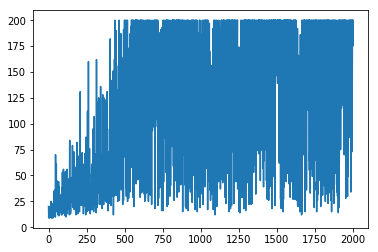

In [25]:
plt.plot(pd.DataFrame(r).rolling(1).median())

In [24]:
eps = 0
len(get_rollout())

200

In [25]:
env = env.unwrapped

In [ ]:
env = gym.wrappers.Monitor(env, './video')
get_rollout()

In [43]:
sess.run(params)

[array([[ 0.26532272, -0.10226207,  0.44927974, -0.23759199,  0.41213411,
          0.31379526, -0.61656754,  0.91364451,  0.25676379, -0.25009515],
        [-0.18139169, -0.75108724, -1.02214912, -0.16599792, -0.1416438 ,
          0.00997386, -0.25418795, -0.92058642,  0.794588  ,  0.13933744],
        [-2.80071066, -2.81870211, -3.09462889, -2.43767401,  2.46650379,
          3.39777339,  3.13641829, -3.27297294,  3.7819417 ,  2.90191829],
        [-1.29890875, -1.14616082, -0.67887961, -1.3504597 ,  0.94994235,
          1.26633113,  1.56998483, -1.15506378,  1.48855505,  1.02346733]]),
 array([-0.26894868, -0.12125683, -0.43884331, -0.20345467, -0.10258974,
        -0.02810778, -0.05574155, -0.11813734, -0.01692586, -0.06300373]),
 array([[ 0.24145752, -0.29639285],
        [ 0.53750177, -0.74106289],
        [ 0.51028752,  0.00981381],
        [ 0.53512085, -0.15693986],
        [-0.42584637,  0.16037685],
        [-0.81362347,  0.14383164],
        [-0.2908393 ,  0.28903195],
  

In [47]:
tf.train.Saver().save(sess, './cartpole-h1.ckpt')

'./cartpole-h1.ckpt'

In [23]:
tf.train.Saver().restore(sess, './cartpole-h1.ckpt')

INFO:tensorflow:Restoring parameters from ./cartpole-h1.ckpt
